Imports

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from skimage import transform
import numpy as np
import pywt
from torch.utils.data import Dataset
import PIL.Image as Image
from math import exp
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

WaveMixSR

In [ ]:
class Level1Waveblock(nn.Module):
    def __init__(self, c):
        super(Level1Waveblock, self).__init__()
        self.conv = nn.Conv2d(c, c // 4, 3,padding = 1)
        self.feedforward = nn.Sequential(
            nn.Conv2d(c, c, 1),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Conv2d(c, c, 1),
            nn.ConvTranspose2d( c, c, 4, stride=2, padding=1),
            nn.BatchNorm2d(c)
        )

    def haar_wavelet_transform(self, x):
        batch_size, coefficients = x.size(0), []

        for i in range(batch_size):
            image = x[i]
            image_np = image.detach().cpu().numpy()
            image_coefficients = []

            for channel in image_np:
                aa,(ad,da,dd) = pywt.dwt2(channel, 'haar')
                image_coefficients.append(aa)
                image_coefficients.append(ad)
                image_coefficients.append(da)
                image_coefficients.append(dd)

            coefficients.append(image_coefficients)

        return torch.tensor(np.array(coefficients)).to(device)

    def forward(self, x):
        x = self.conv(x)
        x = self.haar_wavelet_transform(x)
        x = self.feedforward(x)
        return x.to(device)

In [ ]:
class WaveMixSR(nn.Module):
    def __init__(self,depth,c):
        super(WaveMixSR,self).__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(Level1Waveblock(c))

        self.final = nn.Sequential(
            nn.Conv2d(c, c//2, 3, stride=1, padding=1),
            nn.Conv2d(c//2, 1, 3, stride=1, padding=1)
        )

        self.path1 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bicubic', align_corners = False),
            nn.Conv2d(1, c//2, 3, 1, 1),
            nn.Conv2d(c//2 , c, 3, 1, 1),
        )

        self.path2 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bicubic', align_corners = False),
        )

    def forward(self, img):

        y = img[:, 0:1, :, :]
        crcb = img[:, 1:3, :, :]

        y = self.path1(y)

        for attn in self.layers:
            y = attn(y) + y

        y = self.final(y)

        crcb = self.path2(crcb)

        return  torch.cat((y,crcb), dim=1).to(device)

Loss

In [ ]:
def psnr(img1, img2):
    mse = torch.mean((img1 - img2) ** 2)
    return 20 * torch.log10(torch.sqrt(torch.abs(torch.max(img1)))/ torch.sqrt(mse)).to(device)

class PSNRLoss(torch.nn.Module):
    def __init__(self):
        super(PSNRLoss, self).__init__()

    def forward(self, img1, img2):
        return -psnr(img1, img2)

In [ ]:
def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss / gauss.sum()

def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = _2D_window.expand(channel, 1, window_size, window_size).contiguous()
    return window

def _ssim(img1, img2, window, window_size, channel, size_average = True):
    mu1 = F.conv2d(img1, window, padding = window_size//2, groups = channel)
    mu2 = F.conv2d(img2, window, padding = window_size//2, groups = channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1*mu2

    sigma1_sq = F.conv2d(img1*img1, window, padding = window_size//2, groups = channel) - mu1_sq
    sigma2_sq = F.conv2d(img2*img2, window, padding = window_size//2, groups = channel) - mu2_sq
    sigma12 = F.conv2d(img1*img2, window, padding = window_size//2, groups = channel) - mu1_mu2

    C1 = 0.01**2
    C2 = 0.03**2

    ssim_map = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)

def ssim(img1, img2, window_size = 11, size_average = True):
    (_, channel, _, _) = img1.size()
    window = create_window(window_size, channel)
    window = window.to(img1.device)
    return _ssim(img1, img2, window, window_size, channel, size_average)


class SSIMLoss(torch.nn.Module):
    def __init__(self, window_size = 11):
        super(SSIMLoss, self).__init__()
        self.window_size = window_size

    def forward(self, img1, img2):
        return 1-ssim(img1, img2)

Dataset

In [ ]:
!unzip '/content/drive/MyDrive/DIP/archive.zip'

Archive:  /content/drive/MyDrive/DIP/archive.zip
replace FlowerColorImages.h5? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
from keras.datasets import mnist
from keras.utils import to_categorical
from PIL import Image

class SuperResolutionDataset(Dataset):
    def __init__(self, dataset, upscale_factor):
        self.dataset = dataset
        self.transform = transforms.Compose([
            transforms.Resize((64, 64)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img = self.dataset[idx]
        img_pil = Image.fromarray(img.astype('uint8'))
        img_ycbcr = img_pil.convert('YCbCr')
        lr_img = self.transform(img_ycbcr)
        hr_img = transforms.ToTensor()(img_ycbcr)

        return lr_img, hr_img

# (train_X, _), (test_X, _) = mnist.load_data()

import os
from sklearn.model_selection import train_test_split

image_dir = 'flowers/flowers/'
image_files = np.array([Image.open(os.path.join(image_dir, file)) for file in os.listdir(image_dir)])
train_X, test_X = train_test_split(image_files, test_size=0.2, random_state=42)

upscale_factor = 2

train_dataset = SuperResolutionDataset(train_X[0:100], upscale_factor)
test_dataset = SuperResolutionDataset(test_X[0:100], upscale_factor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False)

Model (PSNR Loss)

In [ ]:
model = WaveMixSR(depth=4, c=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_function = PSNRLoss()

Training

In [ ]:
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs.to(device))
        loss = loss_function(outputs, targets.to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}")

Epoch 1/20, Loss: -11.426039047241211
Epoch 2/20, Loss: -19.232426147460938
Epoch 3/20, Loss: -22.94365966796875
Epoch 4/20, Loss: -25.1080647277832
Epoch 5/20, Loss: -25.916717071533203
Epoch 6/20, Loss: -27.19009323120117
Epoch 7/20, Loss: -28.400187072753905
Epoch 8/20, Loss: -28.733811264038085
Epoch 9/20, Loss: -29.522625350952147
Epoch 10/20, Loss: -30.166158981323242
Epoch 11/20, Loss: -30.721857223510742
Epoch 12/20, Loss: -30.967726135253905
Epoch 13/20, Loss: -31.365422668457033
Epoch 14/20, Loss: -31.662450866699217
Epoch 15/20, Loss: -31.962196044921875
Epoch 16/20, Loss: -32.152439727783204
Epoch 17/20, Loss: -32.28140579223633
Epoch 18/20, Loss: -32.60356834411621
Epoch 19/20, Loss: -33.365161437988284
Epoch 20/20, Loss: -33.36277542114258


Testing

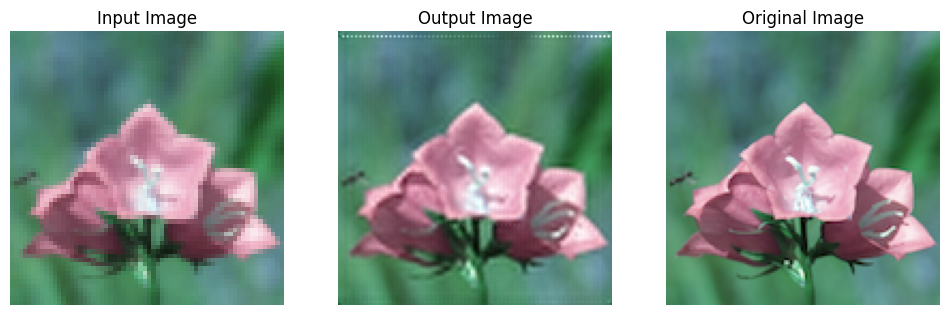

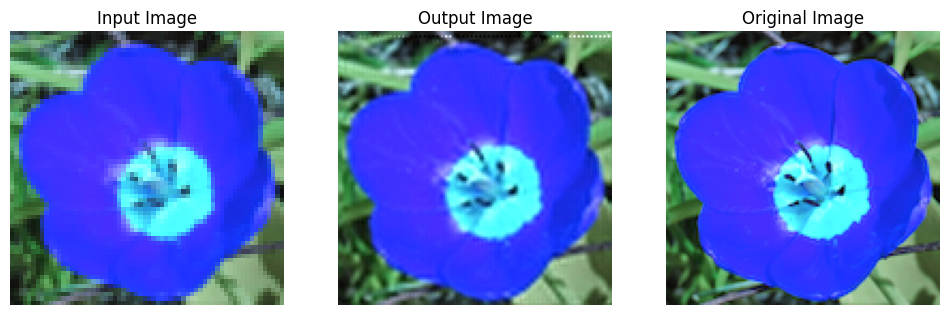

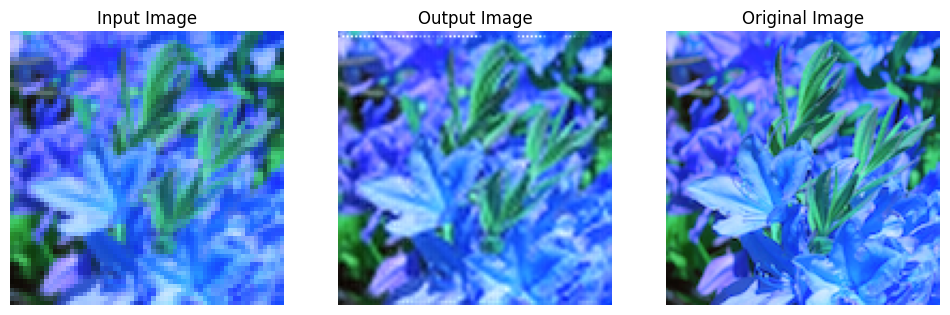

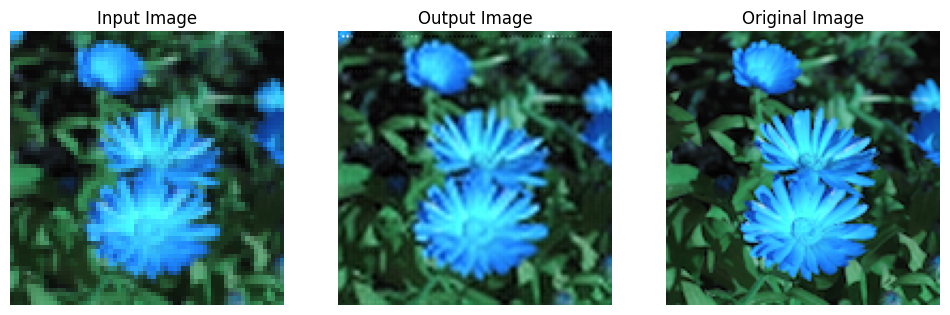

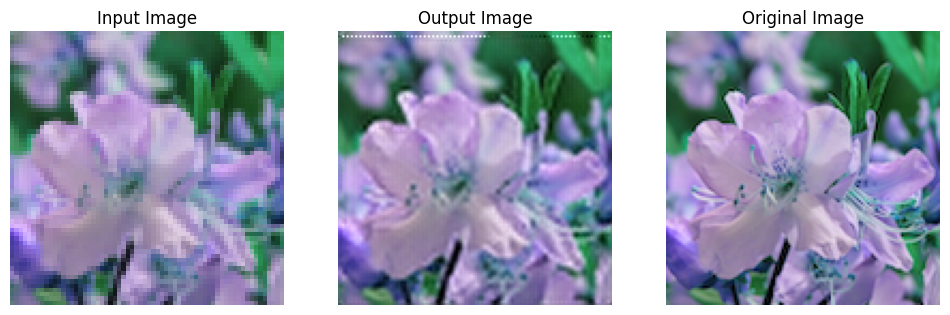

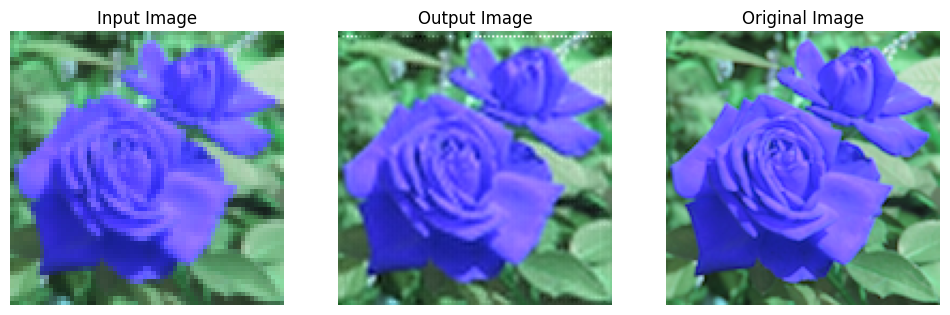

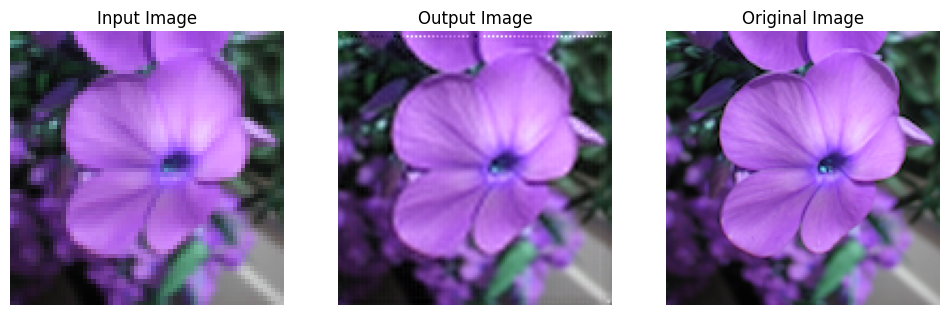

Average PSNR on test set: 34.80038070678711


In [ ]:
import matplotlib.pyplot as plt
import cv2

model.eval()
total_psnr = 0.0
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs.to(device))
        psnr_value = psnr(outputs, targets.to(device))
        total_psnr += psnr_value.item()

        input_image = inputs[3].permute(1, 2, 0).cpu().numpy()
        output_image = outputs[3].permute(1, 2, 0).cpu().numpy()
        target_image = targets[3].permute(1, 2, 0).cpu().numpy()

        plt.figure(figsize=(12, 6))

        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(input_image, cv2.COLOR_YCrCb2RGB))
        plt.title('Input Image')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_YCrCb2RGB))
        plt.title('Output Image')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(cv2.cvtColor(target_image, cv2.COLOR_YCrCb2RGB))
        plt.title('Original Image')
        plt.axis('off')

        plt.show()

average_psnr = total_psnr / len(test_loader)
print(f"Average PSNR on test set: {average_psnr}")

Model (SSIM Loss)

In [ ]:
model = WaveMixSR(depth=4, c=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_function = SSIMLoss()

Training

In [ ]:
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs.to(device))
        loss = loss_function(outputs, targets.to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}")

Epoch 1/20, Loss: 0.3631962442398071
Epoch 2/20, Loss: 0.3524140167236328
Epoch 3/20, Loss: 0.30444501161575316
Epoch 4/20, Loss: 0.2913000869750977
Epoch 5/20, Loss: 0.23738546371459962
Epoch 6/20, Loss: 0.16123523712158203
Epoch 7/20, Loss: 0.12354310989379882
Epoch 8/20, Loss: 0.10218161582946778
Epoch 9/20, Loss: 0.09127828121185302
Epoch 10/20, Loss: 0.08235059261322021
Epoch 11/20, Loss: 0.07713843584060669
Epoch 12/20, Loss: 0.07427536010742188
Epoch 13/20, Loss: 0.07197158098220825
Epoch 14/20, Loss: 0.07196739435195923
Epoch 15/20, Loss: 0.06983806610107422
Epoch 16/20, Loss: 0.06936066627502441
Epoch 17/20, Loss: 0.06841743707656861
Epoch 18/20, Loss: 0.06770328998565674
Epoch 19/20, Loss: 0.06724009513854981
Epoch 20/20, Loss: 0.06685026168823242


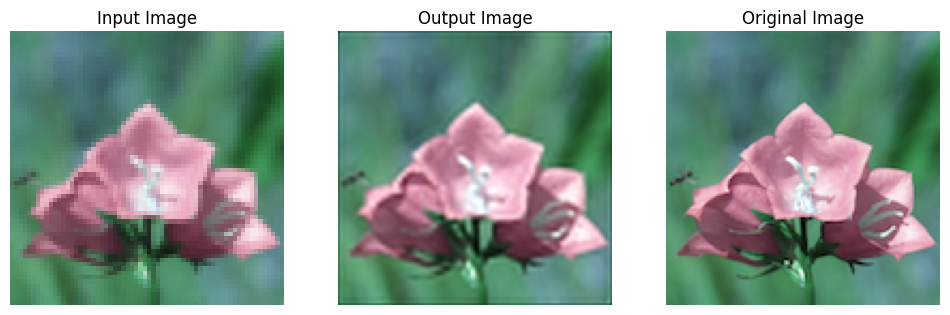

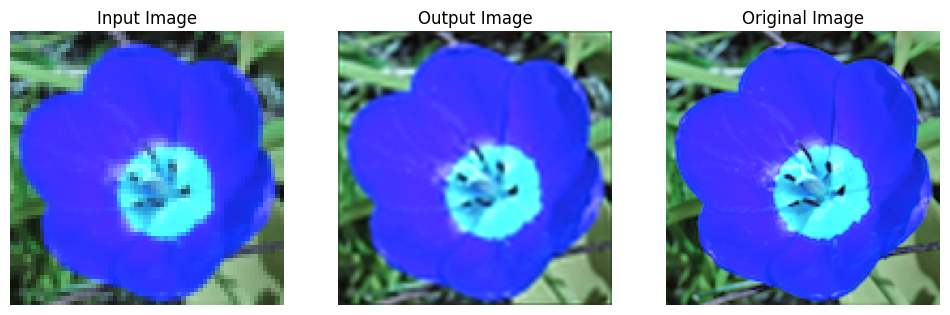

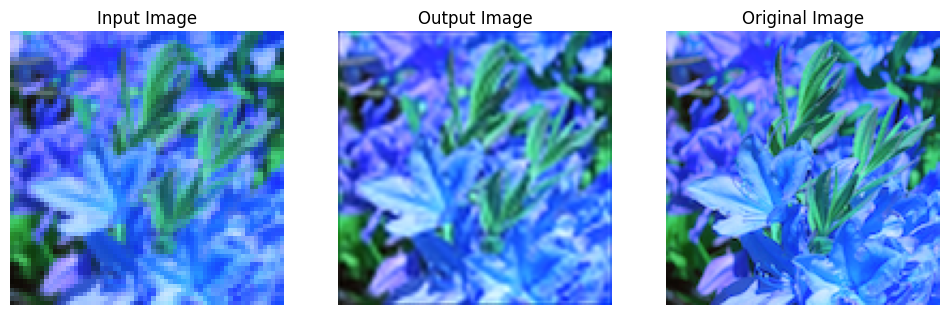

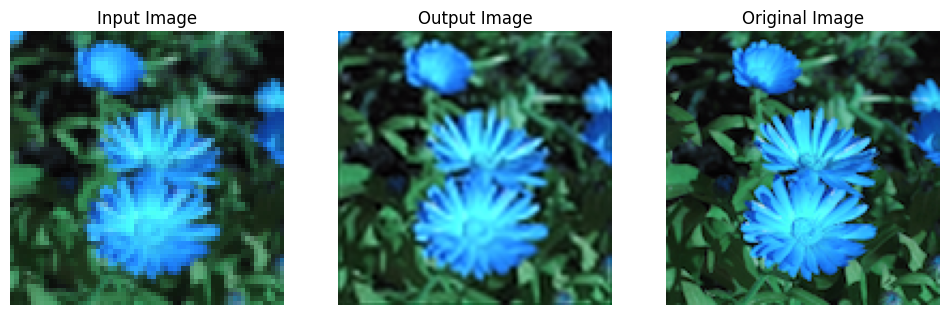

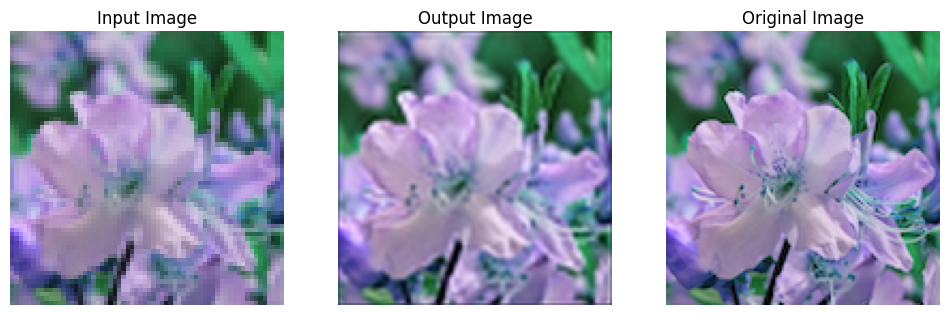

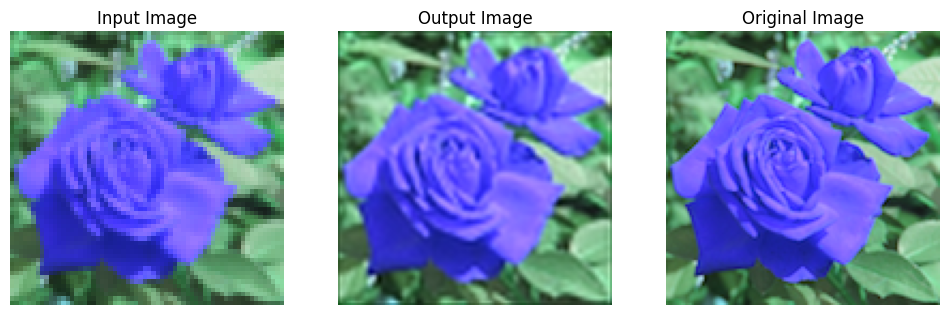

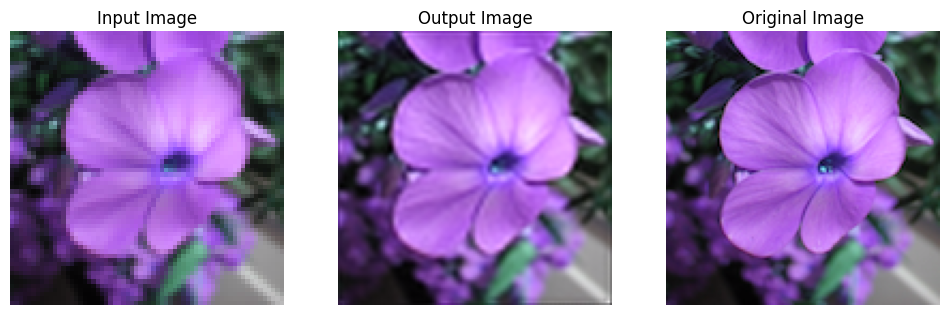

Average SSIM on test set: 0.9339582494327


In [ ]:
import matplotlib.pyplot as plt
import cv2

model.eval()
total_ssim = 0.0
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs.to(device))
        ssim_value = ssim(outputs, targets.to(device))
        total_ssim += ssim_value.item()

        input_image = inputs[3].permute(1, 2, 0).cpu().numpy()
        output_image = outputs[3].permute(1, 2, 0).cpu().numpy()
        target_image = targets[3].permute(1, 2, 0).cpu().numpy()

        plt.figure(figsize=(12, 6))

        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(input_image, cv2.COLOR_YCrCb2RGB))
        plt.title('Input Image')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_YCrCb2RGB))
        plt.title('Output Image')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(cv2.cvtColor(target_image, cv2.COLOR_YCrCb2RGB))
        plt.title('Original Image')
        plt.axis('off')

        plt.show()

average_ssim = total_ssim / len(test_loader)
print(f"Average SSIM on test set: {average_ssim}")